### Unstructured data

Unstructured data refers to data that is not organized in any way, such as:

- images,
- texts,
- sounds,
- videos.


Regardless of the type, we process everything into tensors (multi-dimensional arrays). This may lead to the desire to use ML models and neural networks for analyzing unstructured data.

![](data.png)

Let's start with images.

Create a 2-dim picture with random pixels.

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", palette="husl")


# 2-dim picture 28 x 28 pixel

picture_2d = np.random.uniform(size=(28,28))
picture_2d[0:5,0:5]

array([[0.24423059, 0.70178047, 0.6000905 , 0.02684596, 0.11255575],
       [0.31209228, 0.57311281, 0.6483013 , 0.46144063, 0.32893671],
       [0.19500196, 0.40024096, 0.05999541, 0.28252036, 0.22755812],
       [0.01547923, 0.55961977, 0.28416755, 0.85062969, 0.95047785],
       [0.01192386, 0.89776344, 0.19555436, 0.94795346, 0.65834514]])

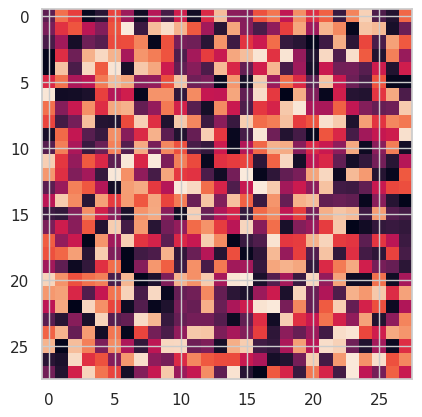

In [3]:
plt.imshow(picture_2d, interpolation='nearest')
plt.show()

## What you can do with pictures - PyTorch

In [4]:
import urllib.request
url = 'https://pytorch.tips/coffee'
fpath = 'coffee.jpg'

# load picture
urllib.request.urlretrieve(url, fpath)

('coffee.jpg', <http.client.HTTPMessage at 0xffff3af62290>)

In [5]:
import matplotlib.pyplot as plt
from PIL import Image # pillow library

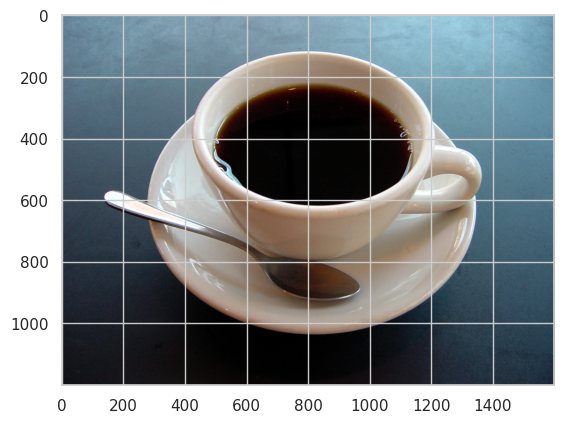

In [6]:
img = Image.open('coffee.jpg')
plt.imshow(img)

let's prepare a ready model

In [7]:
import torch
from torchvision import transforms

We will change the properties of the image slightly

In [8]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize( 
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224,0.225])
])

In [9]:
img_tensor = transform(img)

Let's consider the shape of our image

In [10]:
print(type(img_tensor), img_tensor.shape)

<class 'torch.Tensor'> torch.Size([3, 224, 224])


Creating batch size - an additional dimension (for other images)

In [11]:
batch = img_tensor.unsqueeze(0)
batch.shape

torch.Size([1, 3, 224, 224])

Load alexnet model 

In [12]:
from torchvision import models 
model = models.alexnet(pretrained=True)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/jovyan/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 50.2MB/s] 


Let's write universal code that you can run on both GPU and CPU

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [14]:
model.eval()
model.to(device)
y = model(batch.to(device))
print(y.shape)

torch.Size([1, 1000])


In [15]:
y_max, index = torch.max(y,1)

In [16]:
print(index, y_max)

tensor([967]) tensor([22.8618], grad_fn=<MaxBackward0>)


In [17]:
url = 'https://pytorch.tips/imagenet-labels'
fpath = 'imagenet_class_labels.txt'
urllib.request.urlretrieve(url, fpath)

('imagenet_class_labels.txt', <http.client.HTTPMessage at 0xffff146cf690>)

In [18]:
with open('imagenet_class_labels.txt') as f:
    classes = [line.strip() for line in f.readlines()]
print(classes[967])

967: 'espresso',


In [19]:
prob = torch.nn.functional.softmax(y, dim=1)[0] *100
prob.max()

tensor(87.9956, grad_fn=<MaxBackward1>)

### More pictures with neural network

What other networks and layers can we use for analyzing unstructured data?

> Find the answer to this question in the Keras library documentation

In [21]:
# Loading the Fashion-MNIST dataset
from torchvision import datasets, transforms
# transformacja i normalizacja danych 
transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)


In [22]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

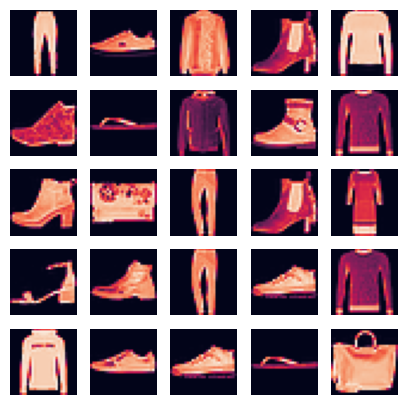

In [23]:
indexes = np.random.randint(0, images.shape[0], size=25)
images_rand = images[indexes]
plt.figure(figsize=(5,5))
for i in range(25):
    plt.subplot(5, 5, i+1)
    image = images_rand[i]
    plt.imshow(image[0])
    plt.axis('off')

plt.show()
plt.close('all')

In [24]:
# Define the network architecture
from torch import nn, optim
import torch.nn.functional as F

model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 10),
                      nn.LogSoftmax(dim = 1)
                     )


In [25]:
# Define the loss
criterion = nn.NLLLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.002)


In [26]:
# Define the epochs
epochs = 30

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    images = images.view(images.shape[0], -1)
    
    # Training pass
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30.. Training loss: 0.487.. Test loss: 0.438.. Test Accuracy: 0.837
Epoch: 2/30.. Training loss: 0.377.. Test loss: 0.427.. Test Accuracy: 0.845
Epoch: 3/30.. Training loss: 0.346.. Test loss: 0.387.. Test Accuracy: 0.864
Epoch: 4/30.. Training loss: 0.322.. Test loss: 0.375.. Test Accuracy: 0.865
Epoch: 5/30.. Training loss: 0.306.. Test loss: 0.371.. Test Accuracy: 0.871
Epoch: 6/30.. Training loss: 0.289.. Test loss: 0.369.. Test Accuracy: 0.865
Epoch: 7/30.. Training loss: 0.279.. Test loss: 0.390.. Test Accuracy: 0.865
Epoch: 8/30.. Training loss: 0.268.. Test loss: 0.369.. Test Accuracy: 0.872
Epoch: 9/30.. Training loss: 0.258.. Test loss: 0.355.. Test Accuracy: 0.878
Epoch: 10/30.. Training loss: 0.251.. Test loss: 0.371.. Test Accuracy: 0.874
Epoch: 11/30.. Training loss: 0.243.. Test loss: 0.363.. Test Accuracy: 0.879
Epoch: 12/30.. Training loss: 0.238.. Test loss: 0.391.. Test Accuracy: 0.870
Epoch: 13/30.. Training loss: 0.233.. Test loss: 0.400.. Test Accuracy: 0

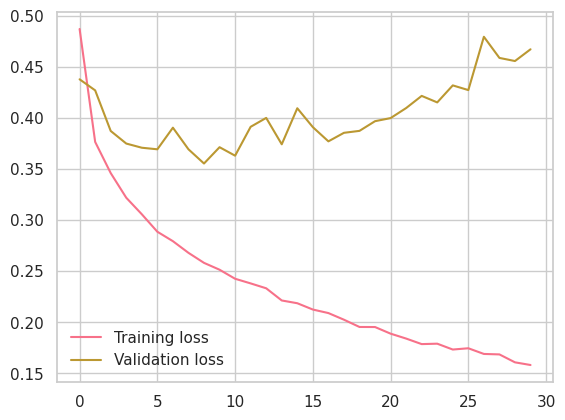

In [27]:
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)

In [28]:
print("My model: \n\n", model, "\n")
print("The state dict keys: \n\n", model.state_dict().keys())

torch.save(model.state_dict(), 'checkpoint.pth')

My model: 

 Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
  (3): LogSoftmax(dim=1)
) 

The state dict keys: 

 odict_keys(['0.weight', '0.bias', '2.weight', '2.bias'])


## Text data and BoW model

In [29]:
import pandas as pd
df_train = pd.read_csv("train.csv")
df_train = df_train.drop("index", axis=1)
print(df_train.head())
print(np.bincount(df_train["label"]))

                                                text  label
0  When we started watching this series on cable,...      1
1  Steve Biko was a black activist who tried to r...      1
2  My short comment for this flick is go pick it ...      1
3  As a serious horror fan, I get that certain ma...      0
4  Robert Cummings, Laraine Day and Jean Muir sta...      1
[17452 17548]


In [30]:
# BoW model 
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(lowercase=True, max_features=10_000, stop_words="english")

cv.fit(df_train["text"])

CountVectorizer(max_features=10000, stop_words='english')

In [ ]:
# vocabulary.
cv.vocabulary_

In [31]:
X_train = cv.transform(df_train["text"])
X_train

In [32]:
# to dense matrix
feat_vec = np.array(X_train[0].todense())[0]
print(feat_vec.shape)
np.bincount(feat_vec)

(10000,)


array([9926,   67,    5,    0,    1,    0,    1])

## OOP for modeling in state space

In [ ]:
import pandas as pd
import numpy as np
 
# data example
df = pd.read_csv("students.csv")
df.head()

In [ ]:
len(df), list(df.columns)

In [ ]:
X = df.drop(columns=['target'])
y = df['target']

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# FIRST prepare pipeline

numeric_features = ['math score','reading score','writing score']
categorical_features = ['sex','race/ethnicity','parental level of education','lunch','test preparation course']

In [ ]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ("num_trans", numeric_transformer, numeric_features),
    ("cat_trans", categorical_transformer, categorical_features)
])

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline(steps=[
    ("preproc", preprocessor),
    ("model", LogisticRegression())
])

In [ ]:
from sklearn import set_config
set_config(display='diagram')
pipeline

> Just remember - pipeline object is a python object. So you can save it as ordinary pickle object. 

In [ ]:
from sklearn.model_selection import train_test_split
X_tr, X_test, y_tr, y_test = train_test_split(X,y,
test_size=0.2, random_state=42)

pipeline.fit(X_tr, y_tr)

score = pipeline.score(X_test, y_test)
print(score)

In [ ]:
import joblib
joblib.dump(pipeline, 'your_pipeline.pkl')

Now the magic start's 

In [ ]:
param_grid = [
              {"preproc__num_trans__imputer__strategy":
              ["mean","median"],
               "model__n_estimators":[2,5,10,100,500],
               "model__min_samples_leaf": [1, 0.1],
               "model":[RandomForestClassifier()]},
              {"preproc__num_trans__imputer__strategy":
                ["mean","median"],
               "model__C":[0.1,1.0,10.0,100.0,1000],
                "model":[LogisticRegression()]}
]

from sklearn.model_selection import GridSearchCV


grid_search = GridSearchCV(pipeline, param_grid,
cv=2, verbose=1, n_jobs=-1)


grid_search.fit(X_tr, y_tr)

grid_search.best_params_

In [ ]:
grid_search.score(X_test, y_test), grid_search.score(X_tr, y_tr)

In [ ]:
df['bad_feature'] = 1

In [ ]:
X = df.drop(columns=['target'])
y = df['target']
X_tr, X_test, y_tr, y_test = train_test_split(X,y,
test_size=0.2, random_state=42)

In [ ]:
numeric_features = ['math score','reading score','writing score', 'bad_feature']

In [ ]:
grid_search = GridSearchCV(pipeline, param_grid,
cv=2, verbose=1, n_jobs=-1)

grid_search.fit(X_tr, y_tr)

grid_search.best_params_

In [ ]:
grid_search.score(X_tr, y_tr), grid_search.score(X_test, y_test)

### Write your transformer

In [ ]:
# your own transformator class

from sklearn.base import BaseEstimator, TransformerMixin

class DelOneValueFeature(BaseEstimator, TransformerMixin):
    """Description"""
    def __init__(self):
        self.one_value_features = []
        
    def fit(self, X, y=None):
        for feature in X.columns:
            unique = X[feature].unique()
            if len(unique)==1:
                self.one_value_features.append(feature)
        return self
    def transform(self, X, y=None):
        if not self.one_value_features:
            return X
        return X.drop(axis='columns', columns=self.one_value_features)

In [ ]:
# New pipeline
pipeline2 = Pipeline([
    ("moja_transformacja",DelOneValueFeature()),
    ("preprocesser", preprocessor),
    ("classifier", LogisticRegression())])
    
pipeline2.fit(X_tr, y_tr)
score2 = pipeline2.score(X_test, y_test)

Thats all! :) 